In [1]:
# Import Libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import pingouin as pg
import seaborn as sns
import numpy as np
import statsmodels.api as sm # biblioteca de modelagem estatística
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import pearsonr # correlações de Pearson

In [2]:
# Create a Spark Session
spark = SparkSession.builder.appName("PCA").getOrCreate()

In [3]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('weather_august.csv')
# Create a Pandas Dataframe
aug_df = spark.createDataFrame(df)
# Convert the PySpark DataFrame to a Pandas DataFrame
aug_df_pd = aug_df.toPandas()
# Show the Dataframe
aug_df_pd

,Precipitation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed
0,0.0,930.45,12.50,12.45,100.0,2.80
1,0.0,930.70,12.60,12.60,100.0,2.25
2,0.0,930.85,12.20,12.20,100.0,1.40
3,0.0,931.05,12.00,12.00,100.0,1.25
4,0.0,930.90,11.80,11.80,100.0,1.25
...,...,...,...,...,...,...
739,0.0,932.35,16.30,11.00,71.0,6.20
740,0.0,932.15,14.80,11.25,79.5,6.10
741,0.0,932.15,13.85,11.20,84.5,6.10
742,0.0,932.30,12.90,10.85,87.5,5.10


In [4]:
# Performing PCA 

# Matrix of correlations between variables
matriz_corr = pg.rcorr(aug_df_pd, method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
matriz_corr

,Precipitation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed
Precipitation,-,*,**,***,***,
Avarage_Atmospheric_Pressure,-0.0642,-,***,**,***,***
Avarage_Temperature,-0.0784,-0.6095,-,***,***,***
Avarage_Dew_Temperature,0.135,-0.0802,-0.1296,-,***,***
Avarage_Relative_Humidity,0.1518,0.4085,-0.8252,0.6366,-,***
Avarage_Wind_Speed,-0.0182,0.2134,-0.1315,-0.4211,-0.1358,-


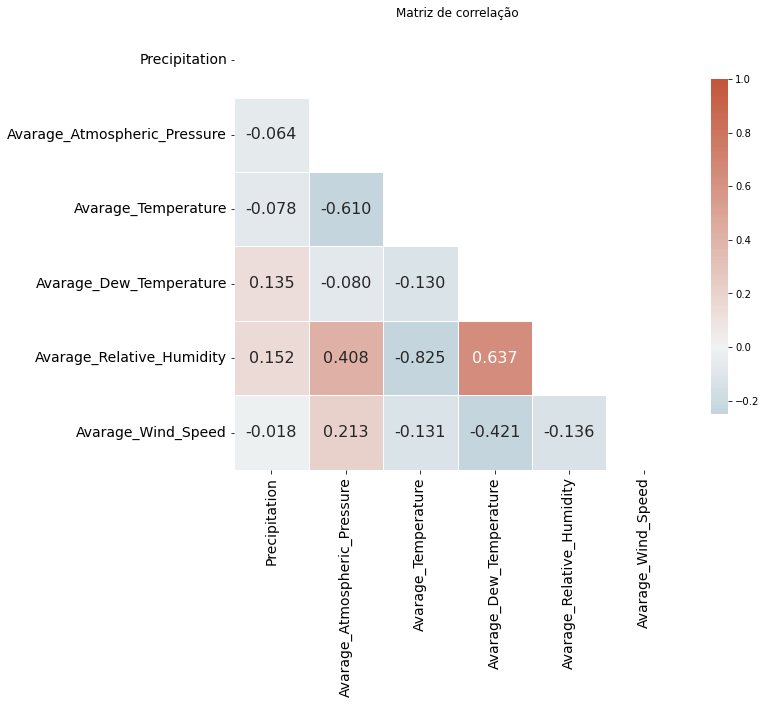

In [5]:
# Another way to plot the same information

corr = aug_df_pd.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, n=256, as_cmap=True)

sns.heatmap(aug_df_pd.corr(), 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin = -.25,
            center=0,
            square=True, 
            linewidths=.5,
            annot = True,
            fmt='.3f', 
            annot_kws={'size': 16},
            cbar_kws={"shrink": .75})

plt.title('Matriz de correlação')
plt.tight_layout()
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.set_ylim(len(corr))

plt.show()

In [6]:
# Bartlett test
bartlett, p_value = calculate_bartlett_sphericity(aug_df_pd)
print(f'Bartlett statistic: {bartlett}')
print(f'p-value : {p_value}')

# KMO Statisticskmo_all
kmo_model = calculate_kmo(aug_df_pd)
print(f'kmo_model : {kmo_model}')

Bartlett statistic: 3120.2471326107934
p-value : 0.0
kmo_model : (array([0.59988462, 0.88729003, 0.38902269, 0.27744356, 0.41941106,
       0.89165109]), 0.4261025370011512)


In [7]:
# Defining the PCA (preliminary procedure)
fa = FactorAnalyzer()
fa.fit(aug_df_pd)

# Getting the Eigenvalues ​​(eigenvalues)
ev, v = fa.get_eigenvalues()
print(ev)

[2.40327005 1.64082028 0.98723437 0.57911605 0.3719537  0.01760555]


In [8]:
# Kaiser Criterion

# Check eigenvalues ​​with values ​​greater than 1
# There are three components above 1

# Parameterizing the PCA for two factors (eigenvalues ​​> 1)
fa.set_params(n_factors = 3, method = 'principal', rotation = None)
fa.fit(aug_df_pd)

# Eigenvalues, variances and accumulated variances
eigen_fatores = fa.get_factor_variance()
eigen_fatores

eigen_table = pd.DataFrame(eigen_fatores)
eigen_table.columns = [f"Fator {i+1}" for i, v in enumerate(eigen_table.columns)]
eigen_table.index = ['Eigenvalue','Variance', 'Accumulated Variance']
eigen_table = eigen_table.T

eigen_table

,Eigenvalue,Variance,Accumulated Variance
Fator 1,2.403270,0.400545,0.400545
Fator 2,1.640820,0.273470,0.674015
Fator 3,0.987234,0.164539,0.838554


In [9]:
# Determining factor loadings
factor_loads = fa.loadings_

load_table = pd.DataFrame(factor_loads)
load_table.columns = [f"Fator {i+1}" for i, v in enumerate(load_table.columns)]
load_table.index = aug_df_pd.columns
load_table

,Fator 1,Fator 2,Fator 3
Precipitation,0.176925,0.231777,0.938029
Avarage_Atmospheric_Pressure,0.615515,-0.573806,-0.129844
Avarage_Temperature,-0.885318,0.320618,-0.006699
Avarage_Dew_Temperature,0.523797,0.726467,-0.087356
Avarage_Relative_Humidity,0.963922,0.162264,-0.025274
Avarage_Wind_Speed,-0.076232,-0.775220,0.286640


In [10]:
# Determining commonalities
commonalities = fa.get_communalities()

commonalities_table = pd.DataFrame(commonalities)
commonalities_table.columns = ['Commonalities']
commonalities_table.index = aug_df_pd.columns
commonalities_table

,Commonalities
Precipitation,0.964921
Avarage_Atmospheric_Pressure,0.724972
Avarage_Temperature,0.886629
Avarage_Dew_Temperature,0.809748
Avarage_Relative_Humidity,0.956115
Avarage_Wind_Speed,0.688940


In [11]:
# Factor results for the dataset observations (predict)
predict_fatores= pd.DataFrame(fa.transform(aug_df_pd))
predict_fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(predict_fatores.columns)]

predict_fatores

,Fator 1,Fator 2,Fator 3
0,0.634995,0.299402,-0.379299
1,0.661854,0.437869,-0.473815
2,0.690589,0.554036,-0.592859
3,0.708318,0.534779,-0.615451
4,0.701665,0.509130,-0.604437
...,...,...,...
739,-0.261595,-0.856998,0.136143
740,0.029562,-0.809181,0.112840
741,0.198826,-0.837395,0.109994
742,0.335621,-0.689150,-0.035475


In [12]:
# Adding to dataset
aug_df_pd_pf = pd.concat([aug_df_pd.reset_index(drop=True), predict_fatores], axis=1)

In [13]:
# Identifying factor scores
scores = fa.weights_

table_scores = pd.DataFrame(scores)
table_scores.columns = [f"Fator {i+1}" for i, v in enumerate(table_scores.columns)]
table_scores.index = aug_df_pd.columns
table_scores

,Fator 1,Fator 2,Fator 3
Precipitation,0.073618,0.141257,0.950158
Avarage_Atmospheric_Pressure,0.256116,-0.349707,-0.131523
Avarage_Temperature,-0.368381,0.195401,-0.006785
Avarage_Dew_Temperature,0.217952,0.442746,-0.088486
Avarage_Relative_Humidity,0.401088,0.098892,-0.025601
Avarage_Wind_Speed,-0.031720,-0.472459,0.290346


In [14]:
# Correlation between factors

# Next, it appears that the correlation between the factors is zero (orthogonal)
corr_fator = pg.rcorr(aug_df_pd_pf[['Fator 1','Fator 2', 'Fator 3']], method = 'pearson', upper = 'pval', decimals = 4, pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})
corr_fator

,Fator 1,Fator 2,Fator 3
Fator 1,-,,
Fator 2,0.0,-,
Fator 3,0.0,0.0,-


In [15]:
# Creating a ranking
aug_df_pd_pf['Ranking'] = 0

for index, item in enumerate(list(eigen_table.index)):
    variancia = eigen_table.loc[item]['Variance']

    aug_df_pd_pf['Ranking'] = aug_df_pd_pf['Ranking'] + aug_df_pd_pf[eigen_table.index[index]]*variancia
    
aug_df_pd_pf.head()

,Precipitation,Avarage_Atmospheric_Pressure,Avarage_Temperature,Avarage_Dew_Temperature,Avarage_Relative_Humidity,Avarage_Wind_Speed,Fator 1,Fator 2,Fator 3,Ranking
0,0.0,930.45,12.5,12.45,100.0,2.80,0.634995,0.299402,-0.379299,0.273812
1,0.0,930.70,12.6,12.60,100.0,2.25,0.661854,0.437869,-0.473815,0.306885
2,0.0,930.85,12.2,12.20,100.0,1.40,0.690589,0.554036,-0.592859,0.330576
3,0.0,931.05,12.0,12.00,100.0,1.25,0.708318,0.534779,-0.615451,0.328693
4,0.0,930.90,11.8,11.80,100.0,1.25,0.701665,0.509130,-0.604437,0.320827


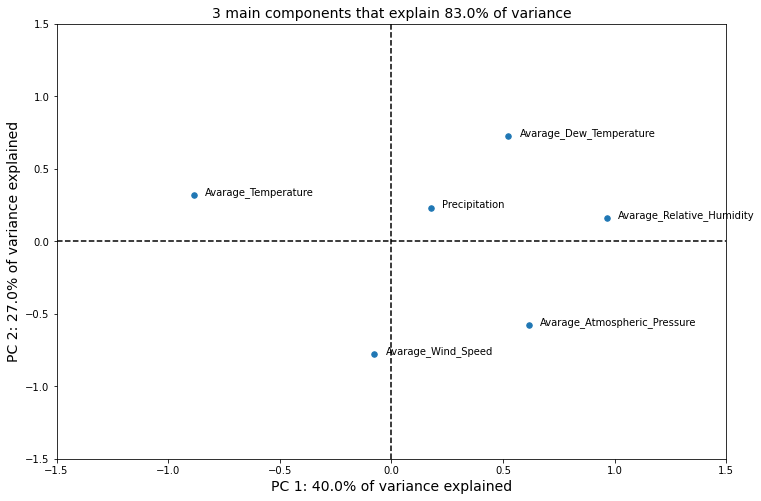

In [16]:
# Chart of factor loadings and their variances in the main components
plt.figure(figsize=(12,8))

table_loads_chart = load_table.reset_index()

plt.scatter(table_loads_chart['Fator 1'], table_loads_chart['Fator 2'], s=30)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = table_loads_chart['Fator 1'],
            y = table_loads_chart['Fator 2'],
            val = table_loads_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='black', ls='--')
plt.axvline(x=0, color='black', ls='--')
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.title(f"{eigen_table.shape[0]} main components that explain {(eigen_table['Variance'].round(2).sum())*100}% of variance", fontsize=14)
plt.xlabel(f"PC 1: {(eigen_table.iloc[0]['Variance'].round(2))*100}% of variance explained", fontsize=14)
plt.ylabel(f"PC 2: {(eigen_table.iloc[1]['Variance'].round(2))*100}% of variance explained", fontsize=14)
plt.show()

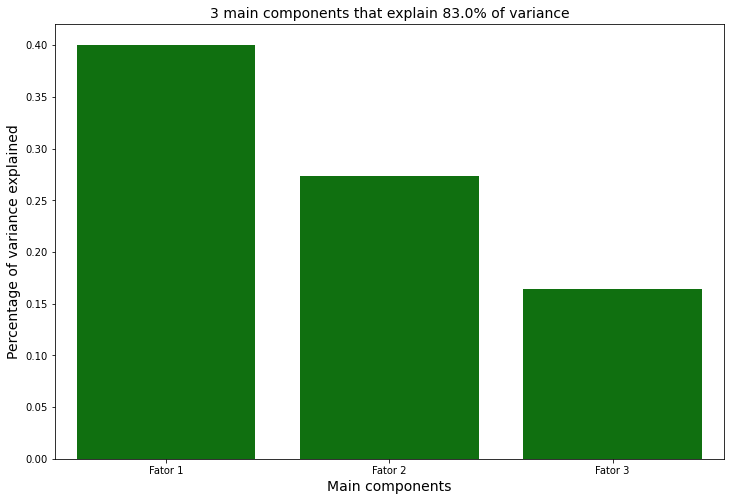

In [17]:
# Plot of the accumulated variance of the principal components
plt.figure(figsize=(12,8))

plt.title(f"{eigen_table.shape[0]} main components that explain {(eigen_table['Variance'].round(2).sum())*100}% of variance", fontsize=14)
sns.barplot(x=eigen_table.index, y=eigen_table['Variance'], data=eigen_table, color='green')
plt.xlabel("Main components", fontsize=14)
plt.ylabel("Percentage of variance explained", fontsize=14)
plt.show()